## Import librarys and define paths

In [42]:

import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import textwrap
import shutil

screen_width = shutil.get_terminal_size().columns

# Define the image name to search for
sequence_path = 'RadarScenes/RadarScenes/data/sequence_4/'
image = "2078692054115.jpg"
image_path = sequence_path + 'camera/' + image
annotations_path = sequence_path + 'scenes.json'
h5_path = sequence_path + 'radar_data.h5'




# define radardata and annotations
with h5py.File(h5_path, 'r') as h5_file:
    radar_data = h5_file['radar_data'][:]

with open(annotations_path, 'r', encoding='utf-8') as json_file:
    annotations = json.load(json_file)  


## Strukture of hdf5 file

hdf5 contains two datasets:
- odemetry: movements refer to a "global" coordinate system
- radar_data: movements refer to the cars coordinate system and movements

In [50]:


def explore_hdf5(h5_path):
    """
    Explore the structure of an HDF5 file and print its hierarchy.
    """
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} | Shape: {obj.shape} | Dtype: {obj.dtype}")

    with h5py.File(h5_path, 'r') as h5_file:
        h5_file.visititems(print_structure)

# Struktur ausgeben
explore_hdf5(h5_path)

Dataset: odometry | Shape: (3253,) | Dtype: [('timestamp', '<i8'), ('x_seq', '<f4'), ('y_seq', '<f4'), ('yaw_seq', '<f4'), ('vx', '<f4'), ('yaw_rate', '<f4')]
Dataset: radar_data | Shape: (139736,) | Dtype: [('timestamp', '<i8'), ('sensor_id', 'u1'), ('range_sc', '<f4'), ('azimuth_sc', '<f4'), ('rcs', '<f4'), ('vr', '<f4'), ('vr_compensated', '<f4'), ('x_cc', '<f4'), ('y_cc', '<f4'), ('x_seq', '<f4'), ('y_seq', '<f4'), ('uuid', 'S32'), ('track_id', 'S32'), ('label_id', 'u1')]


## Radarpoints of one specific timestamp

### 1. Points of x_seq over y_seq

timestamp: 2078692882120


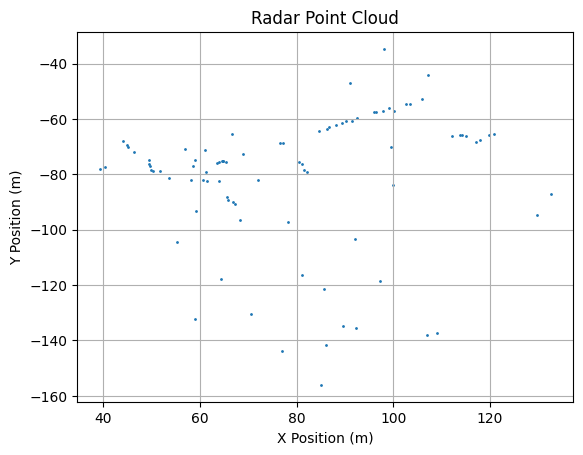

In [ ]:
with h5py.File(h5_path, 'r') as h5_file:
    radar_data = h5_file['radar_data'][:]

timestamp = radar_data["timestamp"][6000]
print(f"timestamp: {timestamp}")

# filter mask for one spepzific timestamp
mask = radar_data["timestamp"][:] == timestamp

x=radar_data["x_seq"][mask]
y=radar_data["y_seq"][mask]

plt.scatter(x, y, s=1)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Radar Point Cloud')
plt.grid()
plt.show()

### 2. x_cc over y_cc compared with the designated picture

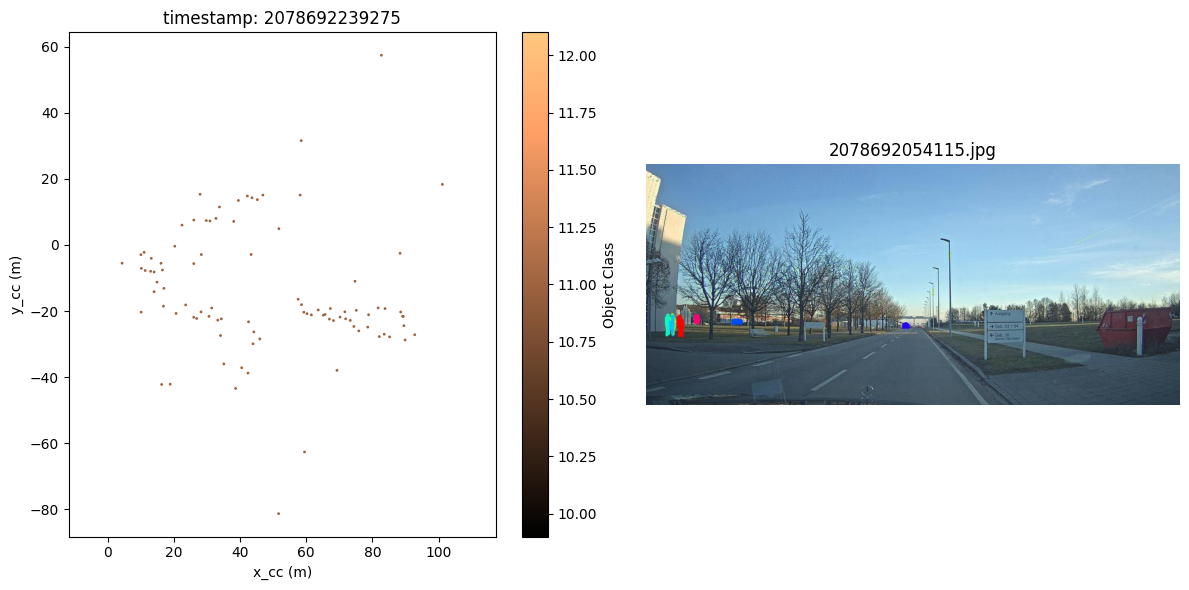

In [ ]:
with h5py.File(h5_path, 'r') as h5_file:
    radar_data = h5_file['radar_data'][:]

# filter mask for one spepzific timestamp
mask = radar_data["timestamp"][:] == timestamp

x_cc = radar_data['x_cc'][mask]
y_cc = radar_data['y_cc'][mask]
labels = radar_data['label_id'][mask]

# subplot with pointcloud compared with related picture
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# point cloud
scatter = ax1.scatter(x_cc, y_cc, c=labels, cmap='copper', s=1)
cbar = plt.colorbar(scatter, ax=ax1, label='Object Class')
ax1.set_xlabel('x_cc (m)')
ax1.set_ylabel('y_cc (m)')
ax1.set_title("timestamp: " + str(timestamp))
ax1.axis('equal')

# picture
img = mpimg.imread(image_path)
ax2.imshow(img)
ax2.axis('off')  # Achsen ausblenden
ax2.set_title(image)

plt.tight_layout()
plt.show()


## All points designated to the same picture 

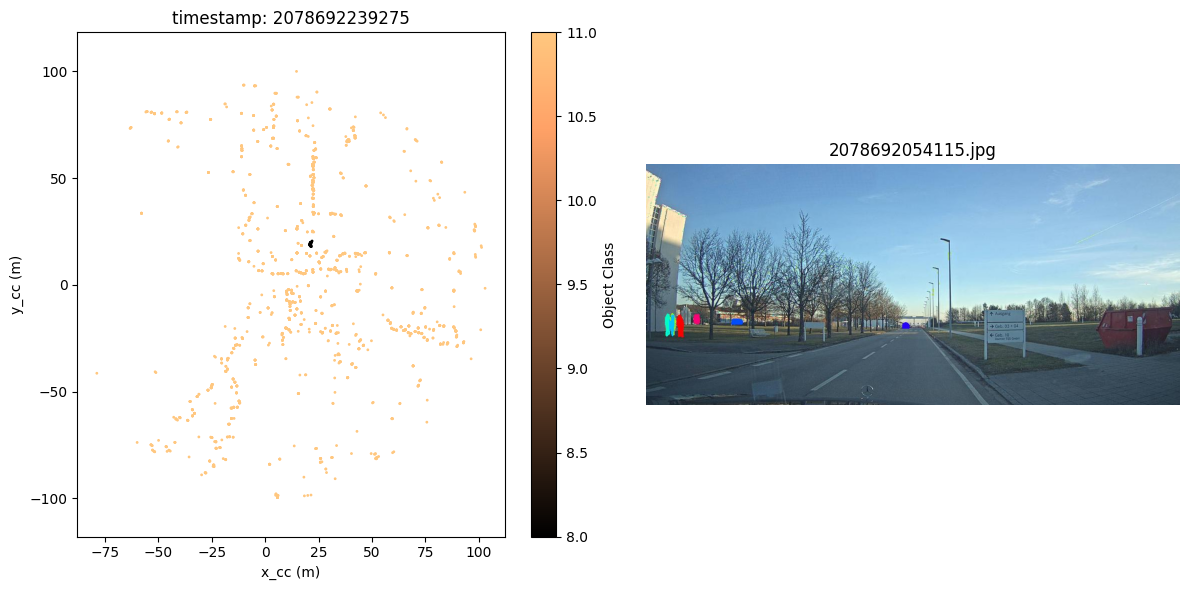

In [ ]:
# Load the JSON data from the file
with open(annotations_path, 'r') as file:
    json_data = json.load(file)

# Load radar data from HDF5 file
with h5py.File(h5_path, 'r') as h5_file:
    radar_data = h5_file['radar_data'][:]
    
matching_timestamps = []
for timestamp, scene in json_data['scenes'].items():
    if scene['image_name'] == image:
        matching_timestamps.append(timestamp)

# save relevant x_cc, y_cc and labels in lists
x_cc = []
y_cc = []
labels = []
for timestamp in matching_timestamps:
    # filter all objects with same timstamp
    mask = radar_data["timestamp"][:] == int(timestamp)
    if not mask.any():
        print(f"no data timestamp: {timestamp}")
    x_cc.extend(radar_data['x_cc'][mask])
    y_cc.extend(radar_data['y_cc'][mask])
    labels.extend(radar_data['label_id'][mask])

# subplot with pointcloud compared with related picture
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the point cloud
scatter = ax1.scatter(x_cc, y_cc, c=labels, cmap='copper', s=1)
cbar = plt.colorbar(scatter, ax=ax1, label='Object Class')
ax1.set_xlabel('x_cc (m)')
ax1.set_ylabel('y_cc (m)')
ax1.set_title("timestamp: " + str(timestamp))
ax1.axis('equal')

# Plot picture
img = plt.imread(image_path)
ax2.imshow(img)
ax2.axis('off')  # Achsen ausblenden
ax2.set_title(image)

plt.tight_layout()
plt.show()